In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nengo
import numpy as np

The LDN is a linear system takes input data $u$ over time and encodes the past history of that input over a window in time $\theta$ in a $q$-dimensional state vector $x$.  In continuous time, this is:

$\dot x = A x + Bu$

In practice, this tends to be implemented in discrete time, so we have

$x[k+1] = A'x[k] + B'u[k]$

Since this is a linear time-invariant system, we should be able to characterize it nicely.  In particular, we should be able to identify the statespace that it is using to encode information, and then we can also directly map into and out of that space.


Here is a Nengo implementation of the LDN.

In [2]:
import scipy.linalg

class LDN(nengo.Process):
    def __init__(self, theta, q, size_in=1):
        self.q = q              # number of internal state dimensions per input
        self.theta = theta      # size of time window (in seconds)
        self.size_in = size_in  # number of inputs

        # Do Aaron's math to generate the matrices A and B so that
        #  dx/dt = Ax + Bu will convert u into a legendre representation over a window theta
        #  https://github.com/arvoelke/nengolib/blob/master/nengolib/synapses/analog.py#L536
        A = np.zeros((q, q))
        B = np.zeros((q, 1))
        for i in range(q):
            B[i] = (-1.)**i * (2*i+1)
            for j in range(q):
                A[i,j] = (2*i+1)*(-1 if i<j else (-1.)**(i-j+1)) 
        self.A = A / theta
        self.B = B / theta        
        
        super().__init__(default_size_in=size_in, default_size_out=q*size_in)

    def make_step(self, shape_in, shape_out, dt, rng, state=None):
        state = np.zeros((self.q, self.size_in))

        # Handle the fact that we're discretizing the time step
        #  https://en.wikipedia.org/wiki/Discretization#Discretization_of_linear_state_space_models
        Ad = scipy.linalg.expm(self.A*dt)
        Bd = np.dot(np.dot(np.linalg.inv(self.A), (Ad-np.eye(self.q))), self.B)

        # this code will be called every timestep
        def step_legendre(t, x, state=state):
            state[:] = np.dot(Ad, state) + np.dot(Bd, x[None, :])
            return state.T.flatten()
        return step_legendre

## Characterizing an LTI system

To characterize an LTI system, we look at its impulse response.  That is, we feed in a single pulse at one point in time ($u(t) \equiv \delta (t)$), and we observe the output.  For a discrete system, we use $u[k] \equiv d[k] \equiv \{1~\text{if}~k = 0~\text{else}~0\}$.  

The reason that we do this is because the system is linear.  This means that if I want to know how the system responds to some other input that isn't an impulse, I can always build that other input up by adding together shifted and scaled versions of the impulse.  Thus, if we have the impulse response, we can always compute what the system's response will be to any other input.

Let's start by finding the impulse response.

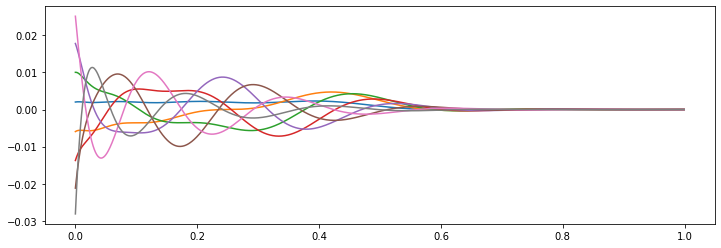

In [3]:
dt = 0.001   # timestep of discretization
theta = 0.5  # time window for LDN
q = 8        # order for LDN

T = theta*2  # length of time to compute impulse response, which I'm making to be longer than theta
             # just to show how things fade out over time

ldn = LDN(theta=theta, q=q)

# make the impulse
u = np.zeros((int(T/dt), 1))
u[0] = 1

# run the LDN with the impulse input
x = ldn.apply(u, dt=dt)

t = np.arange(x.shape[0])*dt
plt.figure(figsize=(12,4))
plt.plot(t, x)
plt.show()

Is there a pattern here to the impulse responses?  Yes, there is.  Each one is (approximately) a scaled version of a Legendre polynomial.

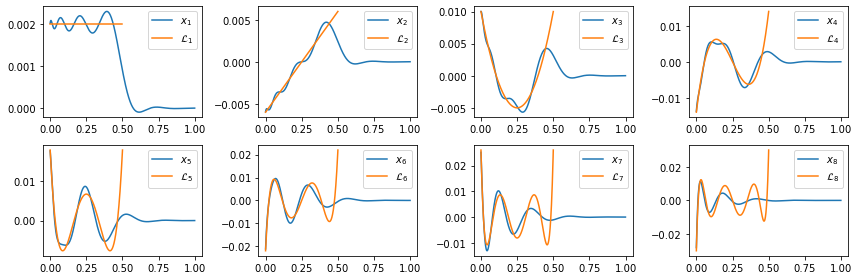

In [4]:
from scipy.special import legendre

plt.figure(figsize=(12,4))

for i in range(q):
    plt.subplot((q+3)//4, 4, i+1)
    plt.plot(t, x[:,i], label=f'$x_{{{i+1}}}$')
    
    tt = np.linspace(-1, 1, 1000)
    v = legendre(i)(tt)
    plt.plot((tt+1)/2*ldn.theta, v/(ldn.theta/dt)*(2*i+1), label=f'$\mathcal{{L}}_{{{i+1}}}$')
    
    plt.legend()
plt.tight_layout()

Let's confirm this by trying with a larger $q$ value.

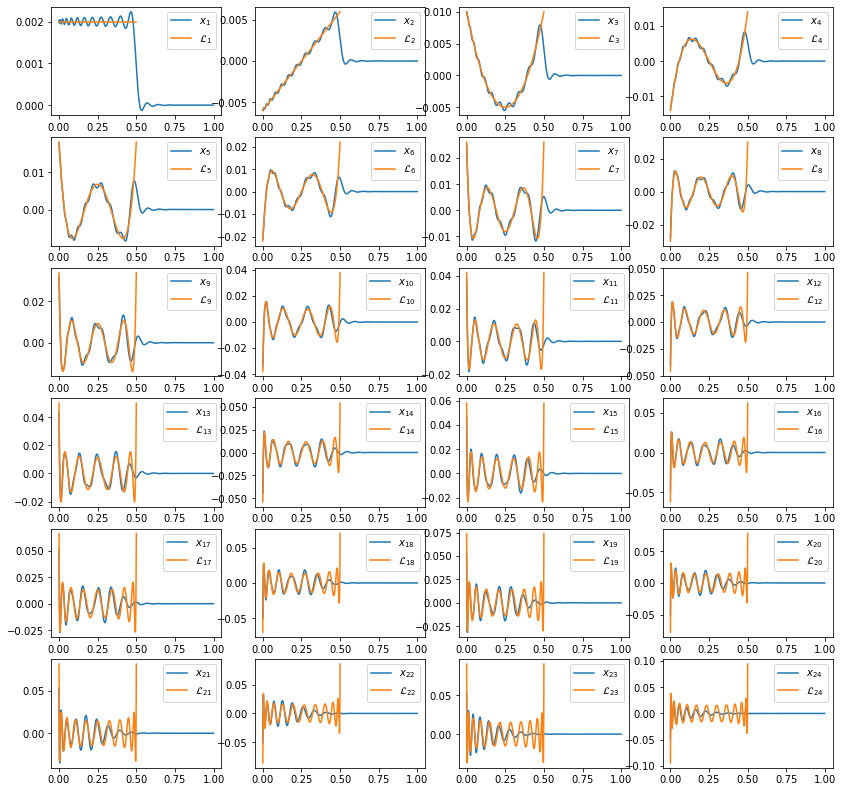

In [5]:
q = 24
ldn = LDN(theta=theta, q=q)
x = ldn.apply(u, dt=dt)

plt.figure(figsize=(14,14))

for i in range(q):
    plt.subplot((q+3)//4, 4, i+1)
    plt.plot(t, x[:,i], label=f'$x_{{{i+1}}}$')
    
    tt = np.linspace(-1, 1, 1000)
    v = legendre(i)(tt)
    plt.plot((tt+1)/2*ldn.theta, v/(ldn.theta/dt)*(2*i+1), label=f'$\mathcal{{L}}_{{{i+1}}}$')
    
    plt.legend()

So, we now have our impulse response.  Let's use this to compute what the output will be for any given input.  

To do this, we just have to break our input down into a bunch of impulses, use our impulse response to figure out what the response would be to that input, and add everything up.

Let's try this for a 1Hz sine-wave input, where we want to know what the state of the system will be after 1 second.

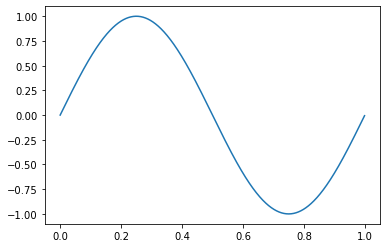

In [6]:
t = np.arange(int(T/dt))*dt

u = np.sin(t*2*np.pi)
plt.plot(t, u)
plt.show()

Since the system is linear, we can treat this sine wave input as the sum of a whole bunch of impulses, each of which has been scaled.  Then the state of the system at any particular point in time can be computed by adding the effects of each impulse.  

So, when we are at the last timestep (`t=1.0` or `k=999`)
The impulse at the first time step (`k=0`) will be scaled by the value of the input at that timestep `u[0]`.  And we want the effect of that impulse after 999 timesteps, so the effect of the first input timestep will be `x[999]*u[0]`.  Similarly, the effect of the next timestep will be `x[998]*u[1]`.  In general, this is `x[999-k]*u[k]`.  All of these effects will be added up to get the final state.

In [7]:
result = np.zeros(ldn.q)
for k in range(len(u)):
    result += x[len(u)-k-1]*u[k]

In [8]:
print(result)

[-6.36616635e-01  3.82284186e-03  6.87075526e-01 -6.99122870e-04
 -5.17878896e-02  4.06844624e-05  1.31724572e-03  1.57342384e-05
 -3.43293401e-05  2.04462122e-05 -2.15020722e-05  2.40857163e-05
 -2.65195911e-05  2.76214556e-05 -3.09491696e-05  3.20655023e-05
 -3.43832951e-05  3.68998298e-05 -3.83194173e-05  4.05858647e-05
 -4.29645780e-05  4.45398448e-05 -4.66973927e-05  4.87051690e-05]


How close is this to what you get what you compute the LDN manually?

In [9]:
M = ldn.apply(u[:,None])
print(M[-1])
assert np.all(np.isclose(M[-1], result))

[-6.36616635e-01  3.82284186e-03  6.87075526e-01 -6.99122870e-04
 -5.17878896e-02  4.06844624e-05  1.31724572e-03  1.57342384e-05
 -3.43293401e-05  2.04462122e-05 -2.15020722e-05  2.40857163e-05
 -2.65195911e-05  2.76214556e-05 -3.09491696e-05  3.20655023e-05
 -3.43832951e-05  3.68998298e-05 -3.83194173e-05  4.05858647e-05
 -4.29645780e-05  4.45398448e-05 -4.66973927e-05  4.87051690e-05]


That looks identical to me.  (And it should be identical, up to floating-point rounding errors).  So we can always determine the response of the LDN in two ways: either simuate the LDN or take the impulse response of the LDN and do the weighted sum of slices through the impulse response multiplication shown.

In fact, since that's a weighted sum, we can also compute it this way, using `[::-1]` to reverse the order of the elements in `x`:

In [10]:
print(u @ x[::-1])

[-6.36616635e-01  3.82284186e-03  6.87075526e-01 -6.99122870e-04
 -5.17878896e-02  4.06844624e-05  1.31724572e-03  1.57342384e-05
 -3.43293401e-05  2.04462122e-05 -2.15020722e-05  2.40857163e-05
 -2.65195911e-05  2.76214556e-05 -3.09491696e-05  3.20655023e-05
 -3.43832951e-05  3.68998298e-05 -3.83194173e-05  4.05858647e-05
 -4.29645780e-05  4.45398448e-05 -4.66973927e-05  4.87051690e-05]


In other words, all we have to do to find out what the response of an LDN is to a particular input is to multiply the input stimulus $u$ with the impulse response!  Let's define that matrix to be $L$ (and switch the order around so we don't have to worry about the `[::-1]` trick to reverse the order of the columns).

In [11]:
L = x[::-1]

## Decoding

Alright, now we know we can use $L$ to take an input and directly convert it to the internal state $x$ that the LDN would have after some amount of time.  But can we reverse this process?  That is, can we take the internal state and decode out what the original input was?  

Well, if we are encoding by multiplying by the matrix $L$, then we can find a decoder by inverting $L$.

In [12]:
inv_L = np.linalg.pinv(L)

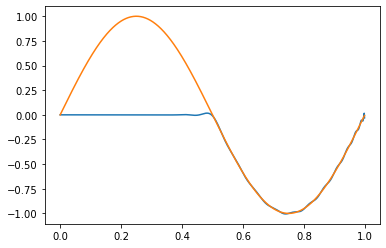

In [13]:
plt.plot(t, (u @ L) @ inv_L)
plt.plot(t, u)

This tells us what information is stored in the LDN state (at time `t=1`).  That is, we are accurately storing information from the past 0.5 seconds.

(Note: if you wanted to just implement a delay of a certain amout of time, then you would just grab a single row out of $L^{-1}$, and that would be your decoder.  But here we are decoding out all the data for all timesteps.)

So what does $L^{-1}$ look like?  Well, let's plot it.

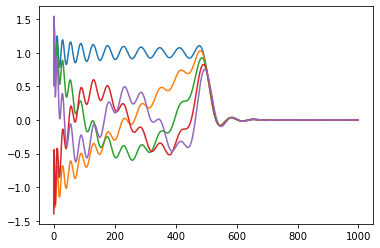

In [14]:
plt.plot(inv_L.T[::-1,:5]);

Hmm, those look kinda familiar.  They're the Legendre polynomials again!

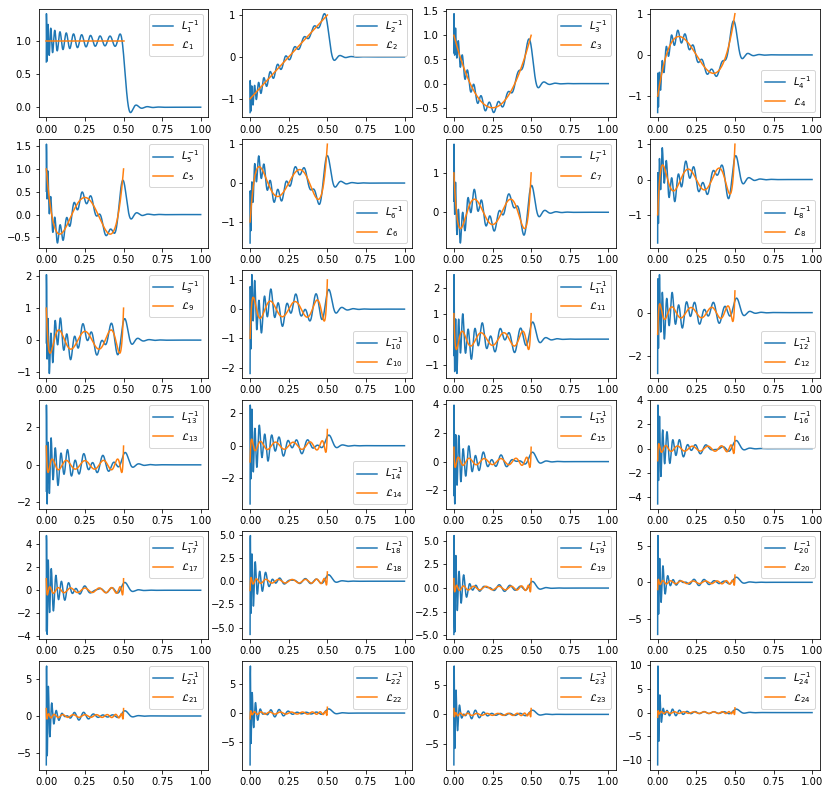

In [15]:
plt.figure(figsize=(14,14))

for i in range(q):
    plt.subplot((q+3)//4, 4, i+1)
    plt.plot(t, inv_L.T[::-1,i], label=f'$L^{{-1}}_{{{i+1}}}$')
    
    tt = np.linspace(-1, 1, 1000)
    v = legendre(i)(tt)
    plt.plot((tt+1)/2*ldn.theta, v, label=f'$\mathcal{{L}}_{{{i+1}}}$')
    
    plt.legend()

What this all means is that we now know how to generate a matrix $L$ that will let us map from our input vector $u$ directly into the LDN state after $u$ is presented, and we can just do that mapping by multiplying $u$ by $L$.  Furthermore, we can reverse this mapping (i.e. projecting from the compressed Legendre space back into normal time) by multiplying by $L^{-1}$.  (Note: since $L$ isn't a square matrix, we're using the pseudo-inverse here, which minimizes the RMSE of the decoded result).

## Improving the LDN decoding

There is an interesting practical advantage to having gone through all this math.  Notice that $L{-1}$ is only *approximately* the Legendre polynomials!  This approximation is due to the discretization and due to the finite order of `q`.  If we want to improve our decoding of a particular delay, then we can directly use $L^{-1}$ instead!  Here's how we could do that:


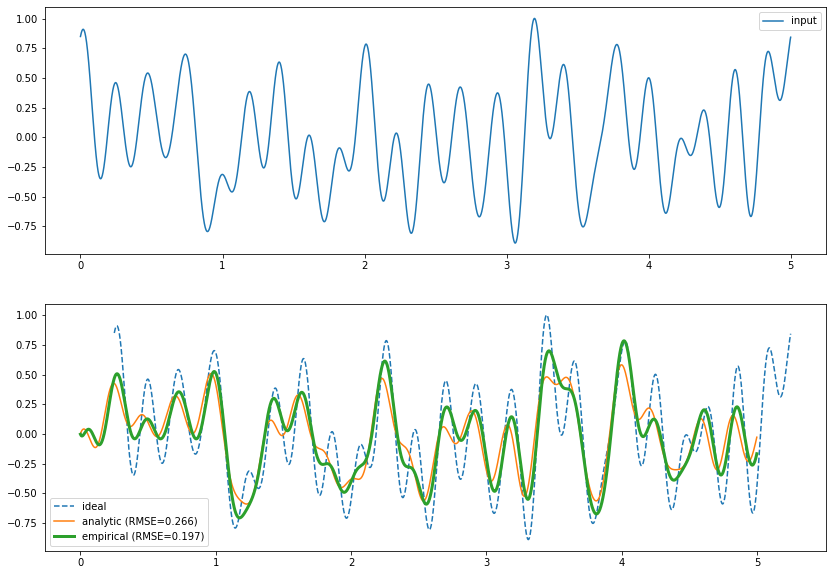

In [16]:
q = 6
theta = 0.5
dt = 0.001
delay = 0.25         # decode a delay of this amount
T = 1.0              # amount of time to compute the impulse response over (assumed to be the same size as input u)

ldn = LDN(theta=theta, q=q)

# compute the impulse response
u = np.zeros((int(T/dt), 1))
u[0] = 1
x = ldn.apply(u, dt=dt)

# create the encoding matrix L and the decoding matrix inv_L
L = x[::-1]
inv_L = np.linalg.pinv(L)

# compute decoder assuming that it's a perfect Legendre representation
def decoder_analytic(q, r):
    r = np.asarray(r)
    m = np.asarray([legendre(i)(2*r - 1) for i in range(q)])
    return m.reshape(q, -1).T
dec_analytic = decoder_analytic(ldn.q, [delay/theta]).T

# compute decoder using the inverse of L
dec_empirical = inv_L[:,int(T/dt*(1-delay))]


# create a random input to test on
u = nengo.processes.WhiteSignal(period=5.0, high=5).run(5.0, dt=dt)

# apply the random input to the LDN
M = ldn.apply(u, dt=dt)

# decode out the delayed versions using the two methods
delay_analytic = M @ dec_analytic
delay_empirical = M @ dec_empirical

# compute the RMSE
shift = int(T/dt*delay)
rmse_analytic = np.sqrt(np.mean((delay_analytic[shift:,0]-u[:-shift,0])**2))
rmse_empirical = np.sqrt(np.mean((delay_empirical[shift:]-u[:-shift,0])**2))

plt.figure(figsize=(14,10))
tt = np.arange(len(u))*dt
plt.subplot(2, 1, 1)
plt.plot(tt, u, label='input')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(tt+delay, u, label='ideal', ls='--')

plt.plot(tt, delay_analytic, label=f'analytic (RMSE={rmse_analytic:.3f})')
plt.plot(tt, delay_empirical, label=f'empirical (RMSE={rmse_empirical:.3f})', lw=3)

plt.legend()
plt.show()

For small `q` (or for high frequencies of input), the empirical decoder is a little bit better.  But as `q` increases, the difference goes away, and indeed the analytic version starts being even better (this is because the analytic version adds in the additional assumption that the input is smooth in time, which the $L^{-1}$ method doesn't take advantage of).

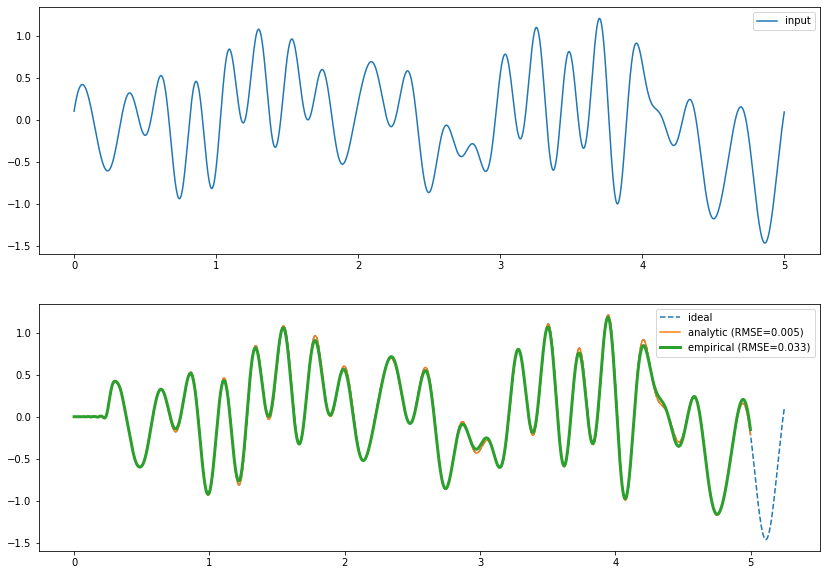

In [17]:
q = 24
theta = 0.5
dt = 0.001
delay = 0.25         # decode a delay of this amount
T = 1.0              # amount of time to compute the impulse response over (assumed to be the same size as input u)

ldn = LDN(theta=theta, q=q)

# compute the impulse response
u = np.zeros((int(T/dt), 1))
u[0] = 1
x = ldn.apply(u, dt=dt)

# create the encoding matrix L and the decoding matrix inv_L
L = x[::-1]
inv_L = np.linalg.pinv(L)

# compute decoder assuming that it's a perfect Legendre representation
def decoder_analytic(q, r):
    r = np.asarray(r)
    m = np.asarray([legendre(i)(2*r - 1) for i in range(q)])
    return m.reshape(q, -1).T
dec_analytic = decoder_analytic(ldn.q, [delay/theta]).T

# compute decoder using the inverse of L
dec_empirical = inv_L[:,int(T/dt*(1-delay))]


# create a random input to test on
u = nengo.processes.WhiteSignal(period=5.0, high=5).run(5.0, dt=dt)

# apply the random input to the LDN
M = ldn.apply(u, dt=dt)

# decode out the delayed versions using the two methods
delay_analytic = M @ dec_analytic
delay_empirical = M @ dec_empirical

# compute the RMSE
shift = int(T/dt*delay)
rmse_analytic = np.sqrt(np.mean((delay_analytic[shift:,0]-u[:-shift,0])**2))
rmse_empirical = np.sqrt(np.mean((delay_empirical[shift:]-u[:-shift,0])**2))

plt.figure(figsize=(14,10))
tt = np.arange(len(u))*dt
plt.subplot(2, 1, 1)
plt.plot(tt, u, label='input')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(tt+delay, u, label='ideal', ls='--')

plt.plot(tt, delay_analytic, label=f'analytic (RMSE={rmse_analytic:.3f})')
plt.plot(tt, delay_empirical, label=f'empirical (RMSE={rmse_empirical:.3f})', lw=3)

plt.legend()
plt.show()